# Ensemble Results for Normalized Detector

This notebook ensembles the results for the test database and calculates the average scores, and performance metrics from these scores. Note that the plotting functions are overkill; I created them for plotting the average scores across 10 models to plot the standard deviation for each model.

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn
import time

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


## Functions

In [5]:
def compute_detections(labels, scores, threshold=0.5):

    scores = np.array(scores)
    labels = np.array(labels)

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

## Initialize Folders and Parameters

In [6]:
main_folder = r'E:\baseline-with-normalization-reduce-tonal'
model_folder = r'E:\baseline-with-normalization-reduce-tonal\models'

model_names = [model_folder + "\\" + "rs-model-0.kt", model_folder + "\\" + "rs-model-1.kt", model_folder + "\\" + "rs-model-2.kt",
            model_folder + "\\" + "rs-model-3.kt", model_folder + "\\" + "rs-model-4.kt", model_folder + "\\" + "rs-model-5.kt",
            model_folder + "\\" + "rs-model-6.kt", model_folder + "\\" + "rs-model-7.kt", model_folder + "\\" + "rs-model-8.kt",
            model_folder + "\\" + "rs-model-9.kt"]

spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

batch_size = 16

## Test Database 

In [ ]:
# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'
temp_folder = main_folder + '\\' + 'temp-ensemble'
db_name = r'E:\baseline-with-normalization-reduce-tonal\final-baseline-db-normalized-rtn.h5'
batch_size = 16

In [7]:
%%time 
# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

CPU times: total: 531 ms
Wall time: 693 ms


In [8]:
all_scores_pos = pd.DataFrame()
all_scores_neg = pd.DataFrame()
all_model_scores = pd.DataFrame()

classification_csv = "classifications-avg.csv"
metric_csv = "metrics-avg.csv"
stats_csv = "stats-avg.csv"

for idx, model in enumerate(model_names):

    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)

    # Initialize the scores and labels
    scores = []
    labels = []

    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)

        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)

        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)

        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)

    scores_series_neg = pd.Series((v[0] for v in scores))
    scores_series_pos = pd.Series((v[1] for v in scores))
    all_scores_neg = pd.concat([all_scores_neg, scores_series_neg.rename('neg model' + str(idx))], axis=1)
    all_scores_pos = pd.concat([all_scores_pos, scores_series_pos.rename('pos model' + str(idx))], axis=1)

In [9]:
print(all_scores_neg.head)

<bound method NDFrame.head of        neg model0    neg model1    neg model2  neg model3    neg model4  \
0    5.866198e-07  9.563091e-07  1.730661e-08    0.000008  3.483835e-06   
1    4.196967e-07  8.406386e-08  5.551685e-07    0.000013  7.511128e-07   
2    1.681505e-05  7.661185e-07  5.336757e-05    0.002898  7.048590e-03   
3    3.673453e-04  2.184069e-04  2.788281e-03    0.006522  2.017099e-03   
4    5.861300e-05  1.829316e-05  1.150193e-04    0.001668  3.749886e-04   
..            ...           ...           ...         ...           ...   
889  9.881200e-01  9.934404e-01  9.982116e-01    0.997395  9.991937e-01   
890  9.837807e-01  9.901502e-01  9.775728e-01    0.972797  9.821177e-01   
891  9.840024e-01  9.878675e-01  9.899110e-01    0.991500  9.892458e-01   
892  9.872613e-01  9.709735e-01  9.971475e-01    0.997652  9.978291e-01   
893  9.906295e-01  9.924414e-01  9.992129e-01    0.997500  9.982328e-01   

       neg model5    neg model6    neg model7    neg model8    neg mo

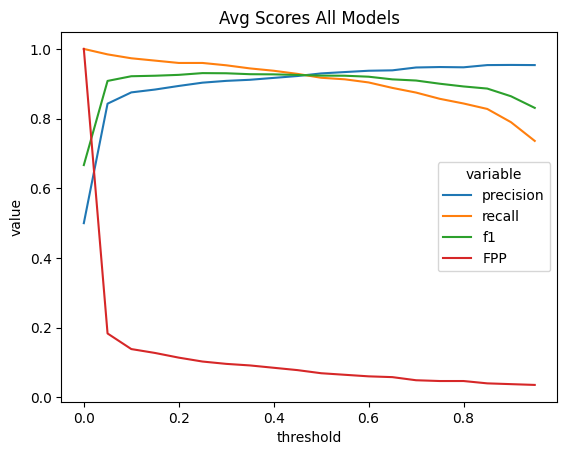

In [10]:
all_scores_pos['mean pos'] = all_scores_pos.mean(axis=1)
all_scores_pos['std'] = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].std(axis=1)
all_scores_neg['mean neg'] = all_scores_neg.mean(axis=1)
all_scores_neg['std'] = all_scores_neg.loc[:, all_scores_neg.columns != "mean"].std(axis=1)

pos_mean_scores_only = all_scores_pos['mean pos'].to_list()

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'
temp_folder = output_dir + '\\' + 'temp'

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, pos_mean_scores_only, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = pos_mean_scores_only[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title("Avg Scores All Models")

db.close()

precision is 0.9297052154195012std of 0.0
recall is 0.9172259507829976std of 0.0
test


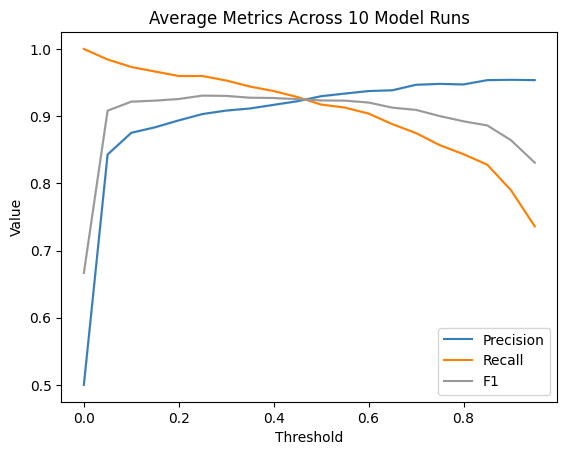

In [14]:
folder = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'

threshold = 0.5

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble\stats-avg.csv']

precision = pd.DataFrame(columns=['threshold'])
recall = pd.DataFrame(columns=['threshold'])
f1 = pd.DataFrame(columns=['threshold'])

for idx, file in enumerate(files):

    csv_f = pd.read_csv(file)

    if idx == 0:
        precision['threshold'] = csv_f['threshold']
        recall['threshold'] = csv_f['threshold']
        f1['threshold'] = csv_f['threshold']

    model_name = file.split("\\")[-1].split('.')[0]
    precision[model_name] = csv_f['precision'].tolist()
    recall[model_name] = csv_f['recall'].tolist()
    f1[model_name] = csv_f['f1'].tolist()

precision['mean'] = precision.loc[:, precision.columns != 'threshold'].mean(axis=1)
precision['std'] = precision.loc[:, precision.columns != 'threshold'].std(axis=1)
precision['mean+std'] = precision['mean'] + precision['std']
precision['mean-std'] = precision['mean'] - precision['std']

recall['mean'] = recall.loc[:, recall.columns != 'threshold'].mean(axis=1)
recall['std'] = recall.loc[:, recall.columns != 'threshold'].std(axis=1)
recall['mean+std'] = recall['mean'] + recall['std']
recall['mean-std'] = recall['mean'] - recall['std']

f1['mean'] = f1.loc[:, f1.columns != 'threshold'].mean(axis=1)
f1['std'] = f1.loc[:, f1.columns != 'threshold'].std(axis=1)
f1['mean+std'] = f1['mean'] + f1['std']
f1['mean-std'] = f1['mean'] - f1['std']

#dfm = precision.melt('threshold', var_name='cols', value_name='vals')
#g = sns.catplot(x="threshold", y="vals", hue='cols', data=dfm, kind='point')

plt.plot(precision['threshold'], precision['mean'], '#377eb8', label='Precision')
plt.fill_between(precision['threshold'], precision['mean-std'], precision['mean+std'], color='#377eb8', alpha=0.2)

plt.plot(recall['threshold'], recall['mean'], '#ff7f00', label='Recall')
plt.fill_between(recall['threshold'], recall['mean-std'], recall['mean+std'], color='#ff7f00', alpha=0.2)

plt.plot(f1['threshold'], f1['mean'], '#999999', label='F1')
plt.fill_between(f1['threshold'], f1['mean-std'], f1['mean+std'], color='#999999', alpha=0.2)

plt.legend()
plt.title('Average Metrics Across 10 Model Runs')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.savefig(folder + '\\' + 'average_metrics.png')

print('precision is ' + str(float(precision[precision['threshold']==threshold]['mean'])) + 'std of ' + str(float(precision[precision['threshold']==threshold]['std'])))
print('recall is ' + str(float(recall[recall['threshold']==threshold]['mean'])) + 'std of ' + str(float(recall[recall['threshold']==threshold]['std'])))

print('test')

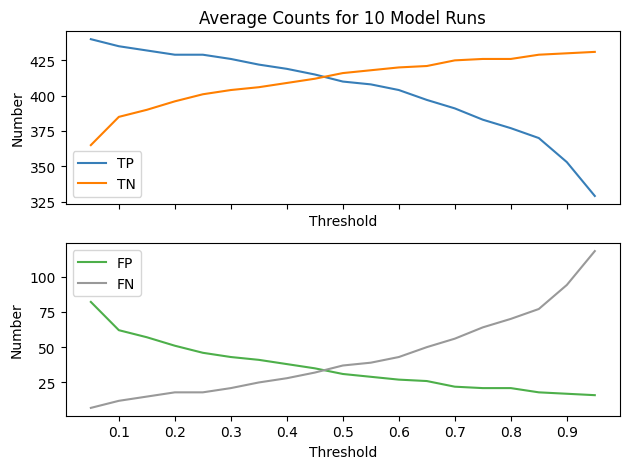

In [15]:
folder = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble\classifications-avg.csv']

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
              0.95, 1]

all = []

for idx, file in enumerate(files):

    class_file = pd.read_csv(file)

    for threshold in thresholds:
        temp = class_file[class_file['threshold'] == threshold]

        predicted, TP, TN, FP, FN = compute_detections(temp['label'], temp['score'], threshold)

        model_name = file.split("\\")[-1].split('.')[0]
        temp_array = [model_name, threshold, TP, TN, FP, FN]

        all.append(temp_array)

        # method deprecated bc slow
        # filled_df = filled_df.append(temp_array, ignore_index=True)

df = pd.DataFrame(all, columns=["model", "threshold", "TP", "TN", "FP", "FN"])

all_calcs = []

for threshold in thresholds:
    df_temp = df[df['threshold'] == threshold]

    TP_avg = df_temp['TP'].mean()
    TP_std = df_temp['TP'].std()

    TN_avg = df_temp['TN'].mean()
    TN_std = df_temp['TN'].std()

    FP_avg = df_temp['FP'].mean()
    FP_std = df_temp['FP'].std()

    FN_avg = df_temp['FN'].mean()
    FN_std = df_temp['FN'].std()

    all_calcs.append([threshold, TP_avg, TP_std, TN_avg, TN_std, FP_avg, FP_std, FN_avg, FN_std])

df_calcs = pd.DataFrame(all_calcs, columns=["threshold", "TP_avg", "TP_std", "TN_avg", "TN_std", "FP_avg",
                                            "FP_std", "FN_avg", "FN_std"])

df_calcs_edited = df_calcs[df_calcs['threshold'] != 0]
df_calcs_edited = df_calcs_edited[df_calcs_edited['threshold'] != 1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title("Average Counts for 10 Model Runs")

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TP_avg'], '#377eb8', label='TP')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TP_avg"] - df_calcs_edited["TP_std"],
                 df_calcs_edited["TP_avg"] + df_calcs_edited["TP_std"], color='#377eb8', alpha=0.2)

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TN_avg'], '#ff7f00', label='TN')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TN_avg"] - df_calcs_edited["TN_std"],
                 df_calcs_edited["TN_avg"] + df_calcs_edited["TN_std"], color='#ff7f00', alpha=0.2)

ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number")
ax1.legend()

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FP_avg'], '#4daf4a', label='FP')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FP_avg"] - df_calcs_edited["FP_std"],
                 df_calcs_edited["FP_avg"] + df_calcs_edited["FP_std"], color='#4daf4a', alpha=0.2)

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FN_avg'], '#999999', label='FN')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FN_avg"] - df_calcs_edited["FN_std"],
                 df_calcs_edited["FN_avg"] + df_calcs_edited["FN_std"], color='#999999', alpha=0.2)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Number")
ax2.legend()

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
# plt.show()
plt.savefig(folder + '\\' + 'average_counts.png')

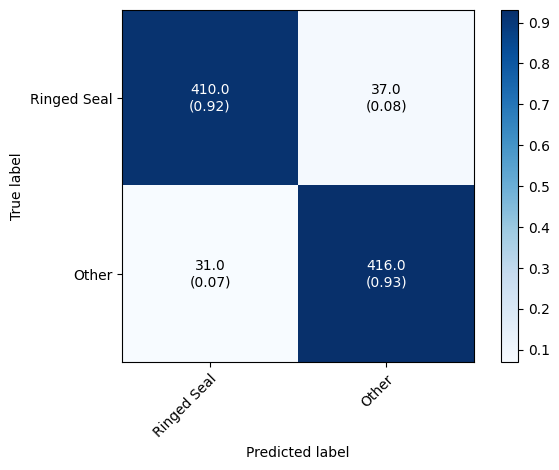

In [16]:
## Plot Confusion Matrix
threshold=0.5

df_confs = df_calcs_edited[df_calcs_edited['threshold']==threshold]

from mlxtend.plotting import plot_confusion_matrix

# Your Confusion Matrix
cm = np.array([[round(float(df_confs['TP_avg']), 2), round(float(df_confs['FN_avg']), 2)],
               [round(float(df_confs['FP_avg']), 2), round(float(df_confs['TN_avg']), 2)]])

error = np.array([[round(float(df_confs['TP_std']), 2), round(float(df_confs['FN_std']), 2)],
               [round(float(df_confs['FP_std']), 2), round(float(df_confs['TN_std']), 2)]])

# Classes
classes = ['Ringed Seal', 'Other']

figure2, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True,
                                   error = error)


plt.tight_layout()
plt.savefig(folder + '\\' + 'confusion_matrix_avg.png')

### Confusion Matrix Sklearn

TN | FP

FN | TP

In [17]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

Confusion Matrix


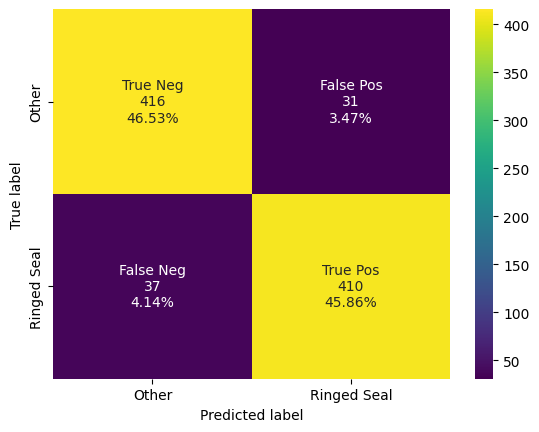

In [18]:
#TN | FP

#FN | TP

threshold = 0.5

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble\classifications-avg.csv'
output_dir = r'E:\baseline-with-normalization-reduce-tonal\metrics\ensemble'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

plt.show()

## Ulu2023

In [19]:
# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'
main_folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023'
temp_folder = main_folder + '\\' + 'temp-ensemble'
db_name = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\ulu2023-db.h5'
batch_size = 16

In [20]:
%%time 
# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/all')

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

CPU times: total: 578 ms
Wall time: 5.97 s


In [21]:
all_scores_pos = pd.DataFrame()
all_scores_neg = pd.DataFrame()
all_model_scores = pd.DataFrame()

classification_csv = "classifications-avg.csv"
metric_csv = "metrics-avg.csv"
stats_csv = "stats-avg.csv"

for idx, model in enumerate(model_names):

    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)

    # Initialize the scores and labels
    scores = []
    labels = []

    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)

        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)

        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)

        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)

    scores_series_neg = pd.Series((v[0] for v in scores))
    scores_series_pos = pd.Series((v[1] for v in scores))
    all_scores_neg = pd.concat([all_scores_neg, scores_series_neg.rename('neg model' + str(idx))], axis=1)
    all_scores_pos = pd.concat([all_scores_pos, scores_series_pos.rename('pos model' + str(idx))], axis=1)

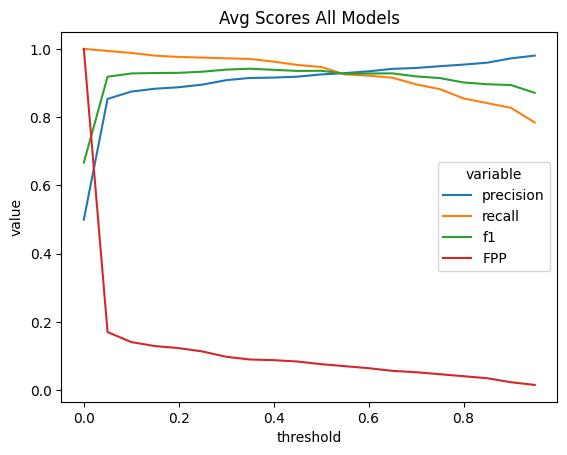

In [22]:
all_scores_pos['mean pos'] = all_scores_pos.mean(axis=1)
all_scores_pos['std'] = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].std(axis=1)
all_scores_neg['mean neg'] = all_scores_neg.mean(axis=1)
all_scores_neg['std'] = all_scores_neg.loc[:, all_scores_neg.columns != "mean"].std(axis=1)

pos_mean_scores_only = all_scores_pos['mean pos'].to_list()

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'
temp_folder = output_dir + '\\' + 'temp'

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, pos_mean_scores_only, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = pos_mean_scores_only[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title("Avg Scores All Models")

db.close()

precision is 0.9291338582677166std of 0.0
recall is 0.9254901960784314std of 0.0
test


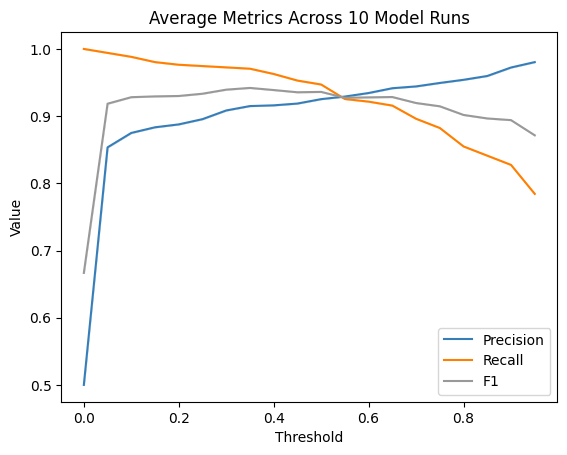

In [23]:
folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'

threshold = 0.55

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble\stats-avg.csv']

precision = pd.DataFrame(columns=['threshold'])
recall = pd.DataFrame(columns=['threshold'])
f1 = pd.DataFrame(columns=['threshold'])

for idx, file in enumerate(files):

    csv_f = pd.read_csv(file)

    if idx == 0:
        precision['threshold'] = csv_f['threshold']
        recall['threshold'] = csv_f['threshold']
        f1['threshold'] = csv_f['threshold']

    model_name = file.split("\\")[-1].split('.')[0]
    precision[model_name] = csv_f['precision'].tolist()
    recall[model_name] = csv_f['recall'].tolist()
    f1[model_name] = csv_f['f1'].tolist()

precision['mean'] = precision.loc[:, precision.columns != 'threshold'].mean(axis=1)
precision['std'] = precision.loc[:, precision.columns != 'threshold'].std(axis=1)
precision['mean+std'] = precision['mean'] + precision['std']
precision['mean-std'] = precision['mean'] - precision['std']

recall['mean'] = recall.loc[:, recall.columns != 'threshold'].mean(axis=1)
recall['std'] = recall.loc[:, recall.columns != 'threshold'].std(axis=1)
recall['mean+std'] = recall['mean'] + recall['std']
recall['mean-std'] = recall['mean'] - recall['std']

f1['mean'] = f1.loc[:, f1.columns != 'threshold'].mean(axis=1)
f1['std'] = f1.loc[:, f1.columns != 'threshold'].std(axis=1)
f1['mean+std'] = f1['mean'] + f1['std']
f1['mean-std'] = f1['mean'] - f1['std']

#dfm = precision.melt('threshold', var_name='cols', value_name='vals')
#g = sns.catplot(x="threshold", y="vals", hue='cols', data=dfm, kind='point')

plt.plot(precision['threshold'], precision['mean'], '#377eb8', label='Precision')
plt.fill_between(precision['threshold'], precision['mean-std'], precision['mean+std'], color='#377eb8', alpha=0.2)

plt.plot(recall['threshold'], recall['mean'], '#ff7f00', label='Recall')
plt.fill_between(recall['threshold'], recall['mean-std'], recall['mean+std'], color='#ff7f00', alpha=0.2)

plt.plot(f1['threshold'], f1['mean'], '#999999', label='F1')
plt.fill_between(f1['threshold'], f1['mean-std'], f1['mean+std'], color='#999999', alpha=0.2)

plt.legend()
plt.title('Average Metrics Across 10 Model Runs')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.savefig(folder + '\\' + 'average_metrics.png')

print('precision is ' + str(float(precision[precision['threshold']==threshold]['mean'])) + 'std of ' + str(float(precision[precision['threshold']==threshold]['std'])))
print('recall is ' + str(float(recall[recall['threshold']==threshold]['mean'])) + 'std of ' + str(float(recall[recall['threshold']==threshold]['std'])))

print('test')

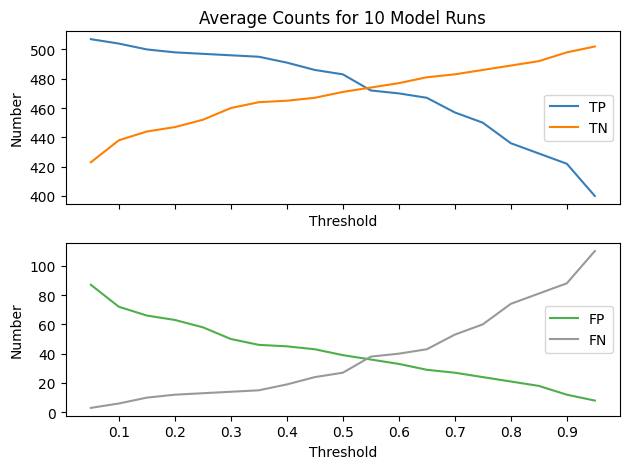

In [24]:
folder = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble\classifications-avg.csv']

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
              0.95, 1]

all = []

for idx, file in enumerate(files):

    class_file = pd.read_csv(file)

    for threshold in thresholds:
        temp = class_file[class_file['threshold'] == threshold]

        predicted, TP, TN, FP, FN = compute_detections(temp['label'], temp['score'], threshold)

        model_name = file.split("\\")[-1].split('.')[0]
        temp_array = [model_name, threshold, TP, TN, FP, FN]

        all.append(temp_array)

        # method deprecated bc slow
        # filled_df = filled_df.append(temp_array, ignore_index=True)

df = pd.DataFrame(all, columns=["model", "threshold", "TP", "TN", "FP", "FN"])

all_calcs = []

for threshold in thresholds:
    df_temp = df[df['threshold'] == threshold]

    TP_avg = df_temp['TP'].mean()
    TP_std = df_temp['TP'].std()

    TN_avg = df_temp['TN'].mean()
    TN_std = df_temp['TN'].std()

    FP_avg = df_temp['FP'].mean()
    FP_std = df_temp['FP'].std()

    FN_avg = df_temp['FN'].mean()
    FN_std = df_temp['FN'].std()

    all_calcs.append([threshold, TP_avg, TP_std, TN_avg, TN_std, FP_avg, FP_std, FN_avg, FN_std])

df_calcs = pd.DataFrame(all_calcs, columns=["threshold", "TP_avg", "TP_std", "TN_avg", "TN_std", "FP_avg",
                                            "FP_std", "FN_avg", "FN_std"])

df_calcs_edited = df_calcs[df_calcs['threshold'] != 0]
df_calcs_edited = df_calcs_edited[df_calcs_edited['threshold'] != 1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title("Average Counts for 10 Model Runs")

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TP_avg'], '#377eb8', label='TP')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TP_avg"] - df_calcs_edited["TP_std"],
                 df_calcs_edited["TP_avg"] + df_calcs_edited["TP_std"], color='#377eb8', alpha=0.2)

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TN_avg'], '#ff7f00', label='TN')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TN_avg"] - df_calcs_edited["TN_std"],
                 df_calcs_edited["TN_avg"] + df_calcs_edited["TN_std"], color='#ff7f00', alpha=0.2)

ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number")
ax1.legend()

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FP_avg'], '#4daf4a', label='FP')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FP_avg"] - df_calcs_edited["FP_std"],
                 df_calcs_edited["FP_avg"] + df_calcs_edited["FP_std"], color='#4daf4a', alpha=0.2)

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FN_avg'], '#999999', label='FN')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FN_avg"] - df_calcs_edited["FN_std"],
                 df_calcs_edited["FN_avg"] + df_calcs_edited["FN_std"], color='#999999', alpha=0.2)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Number")
ax2.legend()

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
# plt.show()
plt.savefig(folder + '\\' + 'average_counts.png')

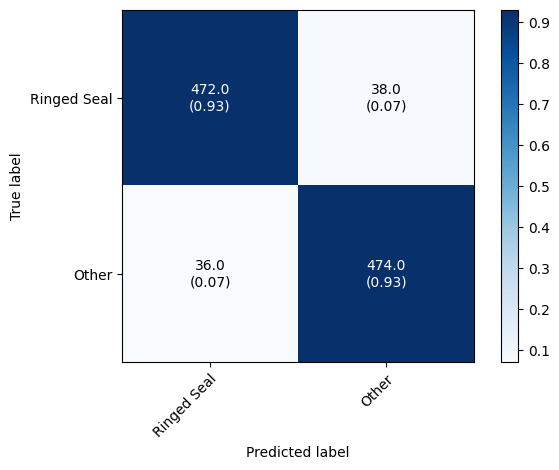

In [26]:
## Plot Confusion Matrix
threshold=0.55

df_confs = df_calcs_edited[df_calcs_edited['threshold']==threshold]

from mlxtend.plotting import plot_confusion_matrix

# Your Confusion Matrix
cm = np.array([[round(float(df_confs['TP_avg']), 2), round(float(df_confs['FN_avg']), 2)],
               [round(float(df_confs['FP_avg']), 2), round(float(df_confs['TN_avg']), 2)]])

error = np.array([[round(float(df_confs['TP_std']), 2), round(float(df_confs['FN_std']), 2)],
               [round(float(df_confs['FP_std']), 2), round(float(df_confs['TN_std']), 2)]])

# Classes
classes = ['Ringed Seal', 'Other']

figure2, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True,
                                   error = error)


plt.tight_layout()
plt.savefig(folder + '\\' + 'confusion_matrix_avg.png')

Confusion Matrix


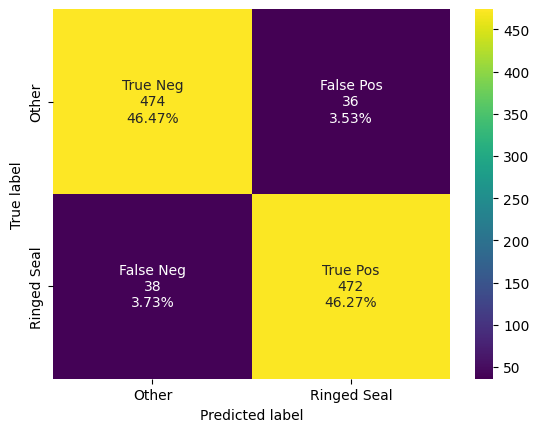

In [27]:
#TN | FP

#FN | TP

threshold = 0.55

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble\classifications-avg.csv'
output_dir = r'E:\baseline-with-normalization-reduce-tonal\ulu2023\metrics\ensemble'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

plt.show()

## Pearce Point

In [28]:
# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'
main_folder = r'E:\baseline-with-normalization-reduce-tonal\pearce-point'
temp_folder = main_folder + '\\' + 'temp-ensemble'
db_name = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\pp-all.h5'
batch_size = 16

In [29]:
%%time 
# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/all')

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

CPU times: total: 141 ms
Wall time: 164 ms


In [30]:
all_scores_pos = pd.DataFrame()
all_scores_neg = pd.DataFrame()
all_model_scores = pd.DataFrame()

classification_csv = "classifications-avg.csv"
metric_csv = "metrics-avg.csv"
stats_csv = "stats-avg.csv"

for idx, model in enumerate(model_names):

    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)

    # Initialize the scores and labels
    scores = []
    labels = []

    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)

        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)

        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)

        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)

    scores_series_neg = pd.Series((v[0] for v in scores))
    scores_series_pos = pd.Series((v[1] for v in scores))
    all_scores_neg = pd.concat([all_scores_neg, scores_series_neg.rename('neg model' + str(idx))], axis=1)
    all_scores_pos = pd.concat([all_scores_pos, scores_series_pos.rename('pos model' + str(idx))], axis=1)

In [39]:
all_scores_neg.to_excel(r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble\neg-scores.xlsx')
all_scores_pos.to_excel(r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble\pos-scores.xlsx')

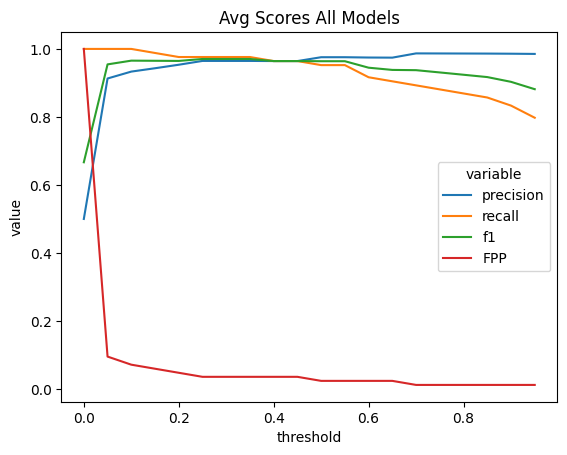

In [31]:
all_scores_pos['mean pos'] = all_scores_pos.mean(axis=1)
all_scores_pos['std'] = all_scores_pos.loc[:, all_scores_pos.columns != "mean"].std(axis=1)
all_scores_neg['mean neg'] = all_scores_neg.mean(axis=1)
all_scores_neg['std'] = all_scores_neg.loc[:, all_scores_neg.columns != "mean"].std(axis=1)

pos_mean_scores_only = all_scores_pos['mean pos'].to_list()

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'
temp_folder = output_dir + '\\' + 'temp'

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, pos_mean_scores_only, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = pos_mean_scores_only[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title("Avg Scores All Models")

db.close()

precision is 0.975609756097561std of 0.0
recall is 0.9523809523809524std of 0.0
test


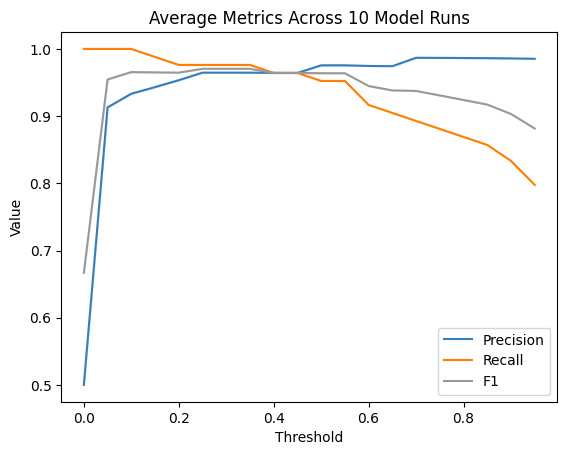

In [32]:
folder = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'

threshold = 0.55

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble\stats-avg.csv']

precision = pd.DataFrame(columns=['threshold'])
recall = pd.DataFrame(columns=['threshold'])
f1 = pd.DataFrame(columns=['threshold'])

for idx, file in enumerate(files):

    csv_f = pd.read_csv(file)

    if idx == 0:
        precision['threshold'] = csv_f['threshold']
        recall['threshold'] = csv_f['threshold']
        f1['threshold'] = csv_f['threshold']

    model_name = file.split("\\")[-1].split('.')[0]
    precision[model_name] = csv_f['precision'].tolist()
    recall[model_name] = csv_f['recall'].tolist()
    f1[model_name] = csv_f['f1'].tolist()

precision['mean'] = precision.loc[:, precision.columns != 'threshold'].mean(axis=1)
precision['std'] = precision.loc[:, precision.columns != 'threshold'].std(axis=1)
precision['mean+std'] = precision['mean'] + precision['std']
precision['mean-std'] = precision['mean'] - precision['std']

recall['mean'] = recall.loc[:, recall.columns != 'threshold'].mean(axis=1)
recall['std'] = recall.loc[:, recall.columns != 'threshold'].std(axis=1)
recall['mean+std'] = recall['mean'] + recall['std']
recall['mean-std'] = recall['mean'] - recall['std']

f1['mean'] = f1.loc[:, f1.columns != 'threshold'].mean(axis=1)
f1['std'] = f1.loc[:, f1.columns != 'threshold'].std(axis=1)
f1['mean+std'] = f1['mean'] + f1['std']
f1['mean-std'] = f1['mean'] - f1['std']

#dfm = precision.melt('threshold', var_name='cols', value_name='vals')
#g = sns.catplot(x="threshold", y="vals", hue='cols', data=dfm, kind='point')

plt.plot(precision['threshold'], precision['mean'], '#377eb8', label='Precision')
plt.fill_between(precision['threshold'], precision['mean-std'], precision['mean+std'], color='#377eb8', alpha=0.2)

plt.plot(recall['threshold'], recall['mean'], '#ff7f00', label='Recall')
plt.fill_between(recall['threshold'], recall['mean-std'], recall['mean+std'], color='#ff7f00', alpha=0.2)

plt.plot(f1['threshold'], f1['mean'], '#999999', label='F1')
plt.fill_between(f1['threshold'], f1['mean-std'], f1['mean+std'], color='#999999', alpha=0.2)

plt.legend()
plt.title('Average Metrics Across 10 Model Runs')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.savefig(folder + '\\' + 'average_metrics.png')

print('precision is ' + str(float(precision[precision['threshold']==threshold]['mean'])) + 'std of ' + str(float(precision[precision['threshold']==threshold]['std'])))
print('recall is ' + str(float(recall[recall['threshold']==threshold]['mean'])) + 'std of ' + str(float(recall[recall['threshold']==threshold]['std'])))

print('test')

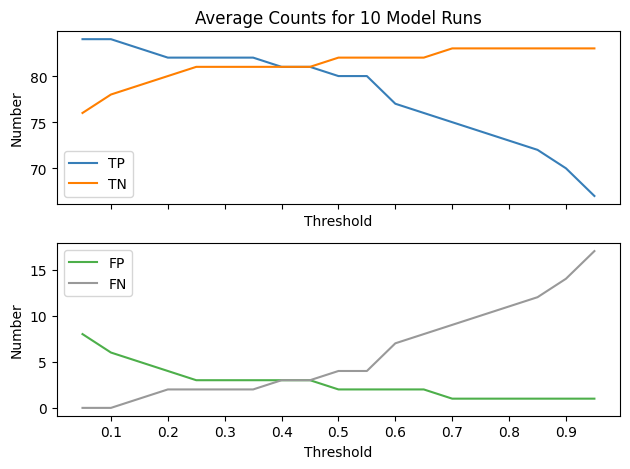

In [33]:
folder = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'

#files = glob.glob(folder + '\*.csv')
files = [r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble\classifications-avg.csv']

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
              0.95, 1]

all = []

for idx, file in enumerate(files):

    class_file = pd.read_csv(file)

    for threshold in thresholds:
        temp = class_file[class_file['threshold'] == threshold]

        predicted, TP, TN, FP, FN = compute_detections(temp['label'], temp['score'], threshold)

        model_name = file.split("\\")[-1].split('.')[0]
        temp_array = [model_name, threshold, TP, TN, FP, FN]

        all.append(temp_array)

        # method deprecated bc slow
        # filled_df = filled_df.append(temp_array, ignore_index=True)

df = pd.DataFrame(all, columns=["model", "threshold", "TP", "TN", "FP", "FN"])

all_calcs = []

for threshold in thresholds:
    df_temp = df[df['threshold'] == threshold]

    TP_avg = df_temp['TP'].mean()
    TP_std = df_temp['TP'].std()

    TN_avg = df_temp['TN'].mean()
    TN_std = df_temp['TN'].std()

    FP_avg = df_temp['FP'].mean()
    FP_std = df_temp['FP'].std()

    FN_avg = df_temp['FN'].mean()
    FN_std = df_temp['FN'].std()

    all_calcs.append([threshold, TP_avg, TP_std, TN_avg, TN_std, FP_avg, FP_std, FN_avg, FN_std])

df_calcs = pd.DataFrame(all_calcs, columns=["threshold", "TP_avg", "TP_std", "TN_avg", "TN_std", "FP_avg",
                                            "FP_std", "FN_avg", "FN_std"])

df_calcs_edited = df_calcs[df_calcs['threshold'] != 0]
df_calcs_edited = df_calcs_edited[df_calcs_edited['threshold'] != 1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title("Average Counts for 10 Model Runs")

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TP_avg'], '#377eb8', label='TP')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TP_avg"] - df_calcs_edited["TP_std"],
                 df_calcs_edited["TP_avg"] + df_calcs_edited["TP_std"], color='#377eb8', alpha=0.2)

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TN_avg'], '#ff7f00', label='TN')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TN_avg"] - df_calcs_edited["TN_std"],
                 df_calcs_edited["TN_avg"] + df_calcs_edited["TN_std"], color='#ff7f00', alpha=0.2)

ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number")
ax1.legend()

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FP_avg'], '#4daf4a', label='FP')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FP_avg"] - df_calcs_edited["FP_std"],
                 df_calcs_edited["FP_avg"] + df_calcs_edited["FP_std"], color='#4daf4a', alpha=0.2)

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FN_avg'], '#999999', label='FN')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FN_avg"] - df_calcs_edited["FN_std"],
                 df_calcs_edited["FN_avg"] + df_calcs_edited["FN_std"], color='#999999', alpha=0.2)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Number")
ax2.legend()

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
# plt.show()
plt.savefig(folder + '\\' + 'average_counts.png')

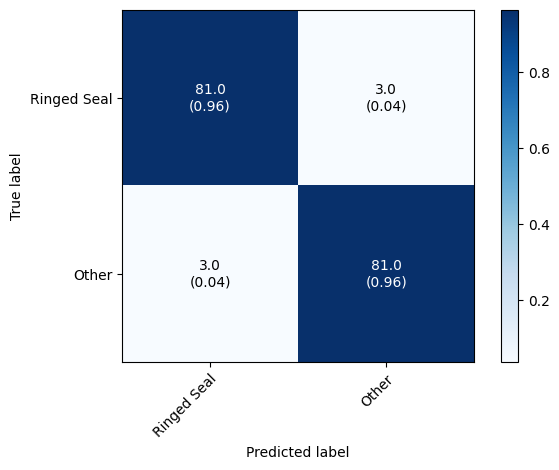

In [35]:
## Plot Confusion Matrix
threshold=0.45

df_confs = df_calcs_edited[df_calcs_edited['threshold']==threshold]

from mlxtend.plotting import plot_confusion_matrix

# Your Confusion Matrix
cm = np.array([[round(float(df_confs['TP_avg']), 2), round(float(df_confs['FN_avg']), 2)],
               [round(float(df_confs['FP_avg']), 2), round(float(df_confs['TN_avg']), 2)]])

error = np.array([[round(float(df_confs['TP_std']), 2), round(float(df_confs['FN_std']), 2)],
               [round(float(df_confs['FP_std']), 2), round(float(df_confs['TN_std']), 2)]])

# Classes
classes = ['Ringed Seal', 'Other']

figure2, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True,
                                   error = error)


plt.tight_layout()
plt.savefig(folder + '\\' + 'confusion_matrix_avg.png')

Confusion Matrix


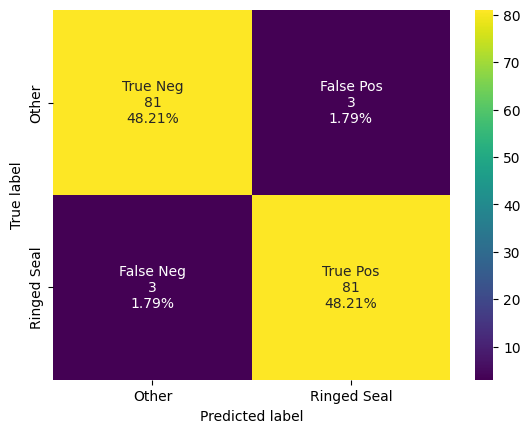

In [36]:
#TN | FP

#FN | TP

threshold = 0.45

classifications_file = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble\classifications-avg.csv'
output_dir = r'E:\baseline-with-normalization-reduce-tonal\pearce-point\metrics\ensemble'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

plt.show()